In [102]:
import pyarrow.parquet as pq
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

In [157]:
df = pq.read_table(source='D:/mashob/0_processed.parquet').to_pandas()

In [158]:
df.head(3)

,title,text_markdown,pluses,minuses,id,author_id,username,url,tags
7,рассада,аня волос нос расти петя аня жопа рассада петя...,5,14,2936217,453525,Misochkin,https://pikabu.ru/story/rassada_2936217,Петр;Анна;Рассада;Волосы;Текст;Переписка;Знако...
11,начальник обед,родственница жаловаться дурдом работа трудитьс...,681,40,6991412,1699826,FluffyMagpie,https://pikabu.ru/story/pro_nachalnikov_i_obed...,Начальник;Руководитель;Обед;Еда;Сотрудники;Текст
15,помогать поиск игра,добрый сутки господин дама подсказывать назван...,2,10,6991359,878346,Keeeesha,https://pikabu.ru/story/pomogite_pozhaluysta_p...,Игры;Мобильное приложение;Гонки;Без рейтинга;П...


In [159]:
len(df)

5121

# Filtered data

Find index of those rows in which the pluses or minuses are not the real value

In [166]:
filtered_df = df[~(((df['minuses'] == 0) & (df['pluses'] == 0)) | (df['minuses'] < 0) | (df['pluses'] < 0))].copy()

In [167]:
len(filtered_df)

4448

In [168]:
def wilson_score(pluses: int, minuses: int, eps: float = 1e-7) -> float:
    n = pluses + minuses
    if n == 0:
        return 0
    p = pluses / (n + eps)
    return _wilson_score(p, n)

def _wilson_score(p: int, n: int) -> float:
    q = 1.96
    return (p + q**2 / (2*n) - q*np.sqrt((p*(1 - p) + q**2/(4*n)) / n)) / (1 + q**2/n)

In [169]:
filtered_df['rating'] = df.apply(lambda row: wilson_score(row['pluses'], row['minuses']), axis=1)

C:\Users\mashu\AppData\Local\Temp\ipykernel_11056\3075728088.py:10: RuntimeWarning: invalid value encountered in sqrt
  return (p + q**2 / (2*n) - q*np.sqrt((p*(1 - p) + q**2/(4*n)) / n)) / (1 + q**2/n)


In [170]:
pd.isnull(filtered_df.rating).count()

4448

In [178]:
def create_label(df, left_border=0, right_border=1):
    intervals = np.linspace(left_border, right_border, endpoint=True, num=4)
    intervals[0] = -np.inf
    intervals[-1] = np.inf
    df["label"] = pd.cut(df.rating, intervals, labels=False, include_lowest=True)

In [179]:
create_label(filtered_df)

In [180]:
filtered_df.label.value_counts()

label
0    2057
1    1392
2     999
Name: count, dtype: int64

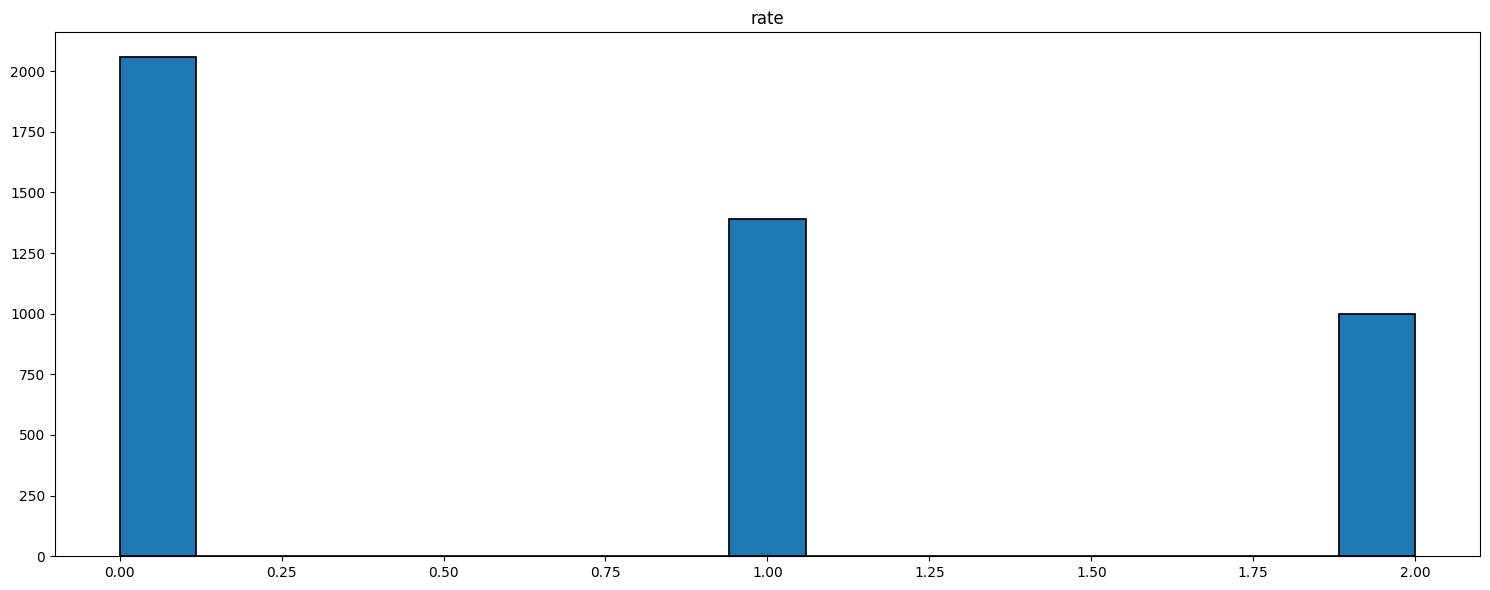

In [182]:
fig, axes = plt.subplots(1, 1, figsize=(15, 6))

sns.histplot(x="label", data=filtered_df, linewidth=1.25,
             alpha=1, ax=axes, zorder=2)
axes.set_title("rate")
axes.set(xlabel=None, ylabel=None)

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Number of posts')

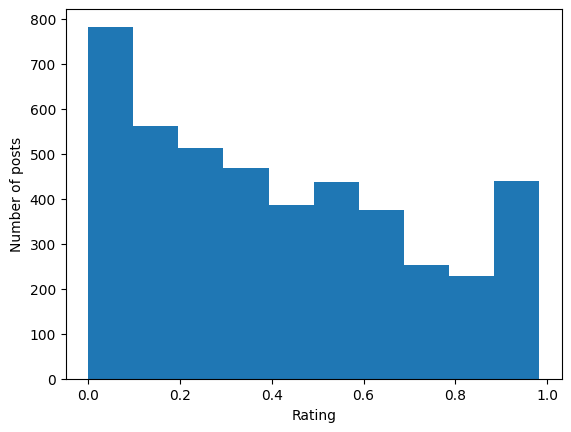

In [183]:
plt.hist(filtered_df.rating)
plt.xlabel('Rating')
plt.ylabel('Number of posts')

# Tf-idf. LogRess

In [184]:
from sklearn.linear_model import LogisticRegression

In [188]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(filtered_df.text_markdown, filtered_df.label, test_size=0.2, random_state=42)


In [189]:
X_train_text = X_train.values
X_test_text = X_test.values
y_train = y_train.values
y_test = y_test.values

In [190]:
v = TfidfVectorizer(norm=None, max_df=0.8, max_features=500, decode_error='replace')
X_train_vector = v.fit_transform(X_train_text)
X_test_vector = v.transform(X_test_text)

In [191]:
clf = LogisticRegression( random_state=64, solver='lbfgs', max_iter=10000, n_jobs=-1) # Обучаем классификатор
clf.fit(X_train_vector, y_train)
y_pred = clf.predict(X_test_vector)

In [192]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [193]:
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred))

0.5224719101123596
              precision    recall  f1-score   support

           0       0.59      0.75      0.66       405
           1       0.40      0.30      0.34       278
           2       0.48      0.38      0.42       207

    accuracy                           0.52       890
   macro avg       0.49      0.48      0.47       890
weighted avg       0.50      0.52      0.50       890



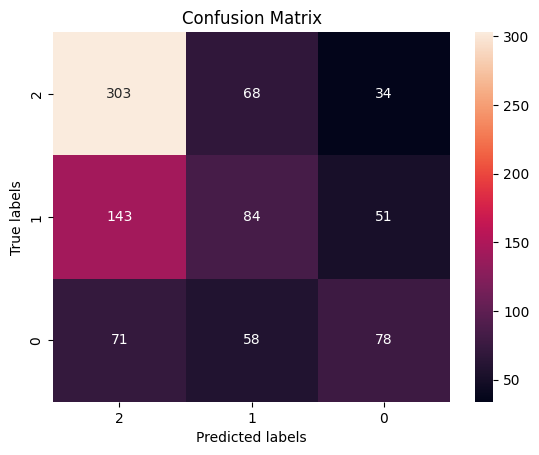

In [194]:
T3_lables = ['2','1','0']    

ax= plt.subplot()

cmm = confusion_matrix(y_test,y_pred)
sns.heatmap(cmm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(T3_lables); ax.yaxis.set_ticklabels(T3_lables);